In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import skorch
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models
import collections
from tqdm import tnrange, tqdm_notebook, tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import numpy as np
import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
from Conv3D_Dataset import ILDDataset

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [3]:
NUM_TOTAL = 1968
NUM_TRAIN = 1783

#add path as absolute path for root dir

im_size = 128

lung_dataset_train = ILDDataset(csv_file=r'C:/Users/Akrofi/Desktop/CS 231/Project/train_labels.csv', 
                          root_dir=r'C:/Users/Akrofi/Desktop/CS 231/Project/train',mask=True, train=True, resize=im_size)#, transform=transform)

lung_dataset_validation = ILDDataset(csv_file=r'C:/Users/Akrofi/Desktop/CS 231/Project/train_labels.csv', 
                           root_dir=r'C:/Users/Akrofi/Desktop/CS 231/Project/validation',mask=True, train=False, resize=im_size)#, transform=transform)

#add path as absolute path for root dir
lung_dataset_test = ILDDataset(csv_file=r'C:/Users/Akrofi/Desktop/CS 231/Project/test_labels.csv', 
                          root_dir=r'C:/Users/Akrofi/Desktop/CS 231/Project/test', mask=True, train=False, resize=im_size)#, transform=transform)


weight0= 1/35
weight1= 1/18
weight2= 1/47

weights = []
for i in tnrange(1783):
    sample = lung_dataset_train[i]
    if sample[1] == 0:
        weights.append(weight0)
        
    elif sample[1] == 1:
        weights.append(weight1)
    else:
        weights.append(weight2)

sampler = sampler.WeightedRandomSampler(torch.cuda.DoubleTensor(weights), len(weights) )


A Jupyter Widget

In [4]:
loader_train = DataLoader(lung_dataset_train, batch_size= 10,
                          sampler = sampler)

loader_val = DataLoader(lung_dataset_validation, batch_size=10,
                        sampler = torch.utils.data.sampler.SubsetRandomSampler(range(190)))

loader_test = DataLoader(lung_dataset_test, batch_size=10)

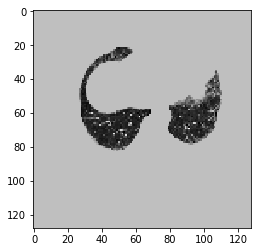

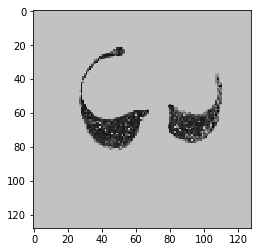

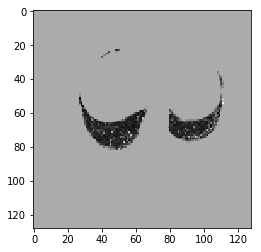

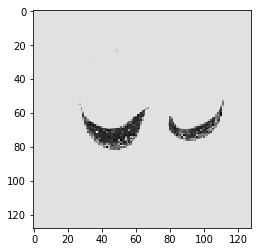

label: 0


In [5]:
#show datasample
sample = lung_dataset_train[190]
plt.imshow(sample[0][0], cmap='gray')
plt.show()
plt.imshow(sample[0][1], cmap='gray')
plt.show()
plt.imshow(sample[0][2], cmap='gray')
plt.show()
plt.imshow(sample[0][3], cmap='gray')
plt.show()
print("label: " + str(sample[1]))

In [6]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)


In [7]:
def get_model():
    """
    Used to fetch model for classification
    """
      
    in_channel = 1
    channel_1 = 32
    channel_2 = 64
    channel_3 = 32
    num_classes = 3

    model = nn.Sequential(
    nn.Conv3d(in_channel,channel_1, kernel_size=5, padding=2, stride= 1 ),
    nn.ReLU(),
    nn.BatchNorm3d(num_features= channel_1),
    nn.Conv3d(channel_1, channel_2, kernel_size=3, padding=1, stride=1),
    nn.Dropout3d(p=0.3),   
    nn.ReLU(),
    nn.BatchNorm3d(num_features= channel_2),
    nn.MaxPool3d(kernel_size=1,stride=1),
    nn.Conv3d(channel_2, channel_3, kernel_size=3, padding=1, stride=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(2097152, num_classes)#/4
)

    
    return model
    

In [8]:
def check_accuracy(loader, model, train=False, val = False):
    predictedStore = []
    solutionStore = []
    if loader.dataset.train and train == True:
        print('Checking accuracy on training set')
    elif val:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            [N,C,H,W] =  [*x.size()]

                                
            scores = model(x.view(N, 1 , C, H , W))
            _, preds = scores.max(1)
            predictedStore.append(preds.view(-1,).cpu().numpy().tolist())
            solutionStore.append(y.data.view(-1,).cpu().numpy().tolist())
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples      
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        
    return acc,predictedStore,solutionStore
 

In [9]:
def train(model, optimizer, epochs=1, overfit=False):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    best_acc = 0;
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            [N,C, H,W] =  [*x.size()]
            
#             print(y)
#             a = np.split(y,16)
#             y = np.zeros(len(a))
#             for i in range(len(a)):
#                 b = collections.Counter(a[i]).most_common()[0][0]
#                 y[i] = b
           
#             y = torch.LongTensor(y)
#             y = y.to(device=device, dtype=torch.long)
            
            
            weights = torch.cuda.FloatTensor([1/35, 1/18 , 1/47])
            scores = model(x.view(N, 1, C, H , W))
            Loss = nn.CrossEntropyLoss()#weight= weights
            loss = Loss(scores, y)
            
            
#             reg = torch.tensor(1e-2, device= device, dtype=dtype)
#             l2_reg = torch.tensor(0. , device= device, dtype=dtype)
#             for param in model.parameters():
#                 l2_reg += torch.norm(param)
#             loss += reg * l2_reg

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
#             if t % print_every == 0:
        print('Iteration %d, loss = %.4f' % (t, loss.item()))
        if(overfit):
            _,predictedStoreTrain,solutionStoreTrain = check_accuracy(loader_train, model, train=True)
        acc,predictedStoreVal,solutionStoreVal = check_accuracy(loader_val, model, val = True)
        if acc > best_acc:
                best_acc = acc
                best_model = model
                predStoreTrain = predictedStoreTrain
                solStoreTrain = solutionStoreTrain
                predStoreVal = predictedStoreVal
                solStoreVal = solutionStoreVal
        print()
    return best_model,predStoreTrain,solStoreTrain,predStoreVal,solStoreVal

In [10]:
model1 = get_model()
optimizer = optim.Adam(model1.parameters(), lr=0.0001)
best_model,predStoreTrain,solStoreTrain,predStoreVal,solStoreVal = train(model1, optimizer, epochs= 5, overfit=True)

Iteration 178, loss = 0.9805
Checking accuracy on training set
Got 1538 / 1783 correct (86.26)
Checking accuracy on validation set
Got 68 / 190 correct (35.79)

Iteration 178, loss = 0.0765
Checking accuracy on training set
Got 1686 / 1783 correct (94.56)
Checking accuracy on validation set
Got 75 / 190 correct (39.47)

Iteration 178, loss = 0.1361
Checking accuracy on training set
Got 1714 / 1783 correct (96.13)
Checking accuracy on validation set
Got 69 / 190 correct (36.32)

Iteration 178, loss = 0.0002
Checking accuracy on training set
Got 1734 / 1783 correct (97.25)
Checking accuracy on validation set
Got 73 / 190 correct (38.42)



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Akrofi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-ac7ce1c915d5>", line 3, in <module>
    best_model,predStoreTrain,solStoreTrain,predStoreVal,solStoreVal = train(model1, optimizer, epochs= 5, overfit=True)
  File "<ipython-input-9-76f10544c01b>", line 13, in train
    for t, (x, y) in enumerate(loader_train):
  File "C:\Users\Akrofi\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 264, in __next__
    batch = self.collate_fn([self.dataset[i] for i in indices])
  File "C:\Users\Akrofi\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 264, in <listcomp>
    batch = self.collate_fn([self.dataset[i] for i in indices])
  File "C:\Users\Akrofi\Documents\GitHub\cs231n_bmi260_project\Conv3D_Dataset.py", line 119, in __getitem__
    filtered_im = transform.resize(filtered_im, (self.resize,

KeyboardInterrupt: 

In [ ]:
#Check Test set
acc,predStoreTest,solStoreTest = check_accuracy(loader_test, best_model)

In [ ]:
import itertools
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
##Actual Plots

y_pred_train = np.concatenate([np.array(i) for i in predStoreTrain])
y_train = np.concatenate([np.array(i) for i in solStoreTrain])

y_pred_val = np.concatenate([np.array(i) for i in predStoreVal]) 
y_val = np.concatenate([np.array(i) for i in solStoreVal])

y_pred_test = np.concatenate([np.array(i) for i in predStoreTest]) 
y_test = np.concatenate([np.array(i) for i in solStoreTest])

cnf_matrix1 = confusion_matrix(y_train, y_pred_train)
cnf_matrix2 = confusion_matrix( y_val, y_pred_val)
cnf_matrix3 = confusion_matrix(y_test, y_pred_test)



class_names = [0,1,2]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=class_names,
                      title='Normalized confusion matrix - Train')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=class_names,
                      title='Normalized confusion matrix - Val')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=class_names,
                      title='Normalized confusion matrix - Test')

plt.show()


In [ ]:
 # Define model
    
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

y_test = label_binarize(y_test, classes = [0,1,2])
y_pred_test = label_binarize(y_pred_test, classes = [0,1,2])
y_val = label_binarize(y_val, classes = [0,1,2])
y_pred_val = label_binarize(y_pred_val, classes = [0,1,2])

precision = dict()
recall = dict()
average_precision = dict()
n_classes = 3
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_val[:, i],
                                                        y_pred_val[:, i])
    average_precision[i] = average_precision_score(y_val[:, i], y_pred_val[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_val.ravel(),
    y_pred_val.ravel())
average_precision["micro"] = average_precision_score(y_val, y_pred_val,
                                                     average="micro")

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["micro"], precision["micro"],
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i in range(n_classes):
    plt.plot(recall[i], precision[i],
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

print(precision)
print(recall)